# Enron POI Identification

## Introduction

Enron, one of the largest US companies, collapsed into bankruptcy in 2002 due to widespread corporate fraud. As a result of the federal investigation, confidential information was made public, including emails and financial data for executives.  

We will build a POI (Person of Interest) identifier to extract individuals involved in the fraud from the data. We will use machine learning and `sklearn` to do so.

## Resources

We will have a few resources to ease the process:
- `final_project_dataset.pkl` is the dataset we're going to investigate
- **Starter code and helper functions are provided**: it reads in the data, takes our features of choice, then puts them into a numpy array (the format sklearn functions assume). We just have to engineer the features, pick and tune an algorithm, and to test and evaluate our identifier. For example:
    - `featureFormat()` to convert the dictionary into a numpy array of features: this is the only way we can make it work with Scickit Learn.
    - `targetFeatureSplit()`, to separate the feature (returned by `featureFormat()`) we want to predict from the others.
- **Data is preprocessed**: Enron email and financial data are combined into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.
    - **financial features**: `['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']` (all units are in US dollars)

    - **email features**: `['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']` (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)

    - **POI label**: `[‘poi’]` (boolean, represented as integer)

## Method

Machine learning will prove extremely useful in investigating the Enron case. We're dealing with a large dataset with a lot of different features. Our goal is simple: identifying POIs. This means that we're going to end up classifying the individuals in the dataset, between POIs and non-POIs. Machine learning will help us discover hidden patterns in the data and extract valuable information, inferring classes from observations.

- We will first **read in** the data.
- We will **visualize** it, plotting salary on the x axis and the other features on the y axis.
- We will then **detect outliers**.
- We will **create** new, better **features**.
- Then, we will select the features we will use for classification. We'll just throw in all the features, **use cross validation** to determine the features that will best generalize and use them in the classifier. 
- We will then **try different classifiers**, tune them and try to achieve the **best prediction and recall rates** without overfitting.
- Finally, we will make the classifier, the dataset and the list of features available to anyone who wants to use them.

## Reading in the data

In [1]:
import sys
import pickle
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

import warnings
warnings.filterwarnings('ignore')

### Task 1: Select what features we'll use (The first feature must be "poi")
features_list = ['poi','salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus',
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses',
                 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']

### Loading the dictionary containing the dataset
data_dict = pickle.load(open("final_project_dataset.pkl", "rb"))
my_dataset = data_dict

/Users/hadrien/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Getting to know the data

We're going to use a pandas dataframe to extract basic information from our dataset, indexing it on the keys of the dictionary (the names of the individuals).

In [2]:
import pandas as pd
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.head()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
ALLEN PHILLIP K,201955,2902,2869717,4484442,NaN,4175000,phillip.allen@enron.com,-126027,-3081055,1729541,...,47,1729541,2195,152,65,False,304805,1407,126027,NaN
BADUM JAMES P,NaN,NaN,178980,182466,NaN,NaN,NaN,NaN,NaN,257817,...,NaN,257817,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,NaN,NaN,james.bannantine@enron.com,-560222,-5104,5243487,...,39,4046157,29,864523,0,False,NaN,465,1757552,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,frank.bay@enron.com,-82782,-201641,63014,...,NaN,NaN,NaN,69,NaN,False,NaN,NaN,145796,NaN


We can already see that we have `NaN` values in our dataset. We will deal with this later.  

Right now, let's get a little more information about the dataset.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
loan_advances                146 non-null object
bonus                        146 non-null object
email_address                146 non-null object
restricted_stock_deferred    146 non-null object
deferred_income              146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
from_poi_to_this_person      146 non-null object
exercised_stock_options      146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
long_term_incentive          146 non-null object


From this, we know that there are 146 entries in the dataset, defined by 21 variables. Our `POI` variable is a boolean, so we can easily know how many persons of interests are in the dataset.

In [4]:
sum(df['poi'])

18

There are 18 declared persons of interest in the dataset. There should be more (Katie identified 35 from [press documents](http://usatoday30.usatoday.com/money/industries/energy/2005-12-28-enron-participants_x.htm
)), but only 18 appear in this dataset. This could be due to various reasons: maybe these persons were declared innocent in the end, maybe we only have a portion of the dataset where the 18 should be used to train a classifier to identify the 17 left...  

It would be interesting to do a little digging, but for the purpose of this project, **the dataset with 18 POIs is the one we will work with**.

## Visualizing the data

Now that we have a dataframe, we can easily visualize all of our features as a scatter plot. For example we can plot salary on x  against another feature on y. We will not define a function to plot the features: pandas dataframe coupled with matplotlib will be enough.  

Now is also a good time to get rid of `NaN` values, otherwise we will get errors while plotting. We will start with this. We will use `np.nan` to deal with the `NaN` values, since this will allow us to perform vectorized operations.

In [5]:
import numpy as np

df = df.replace('NaN', np.nan)

Let's take another quick look at our dataset to see how it was affected, before visualizing our variables.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       95 non-null float64
to_messages                  86 non-null float64
deferral_payments            39 non-null float64
total_payments               125 non-null float64
loan_advances                4 non-null float64
bonus                        82 non-null float64
email_address                111 non-null object
restricted_stock_deferred    18 non-null float64
deferred_income              49 non-null float64
total_stock_value            126 non-null float64
expenses                     95 non-null float64
from_poi_to_this_person      86 non-null float64
exercised_stock_options      102 non-null float64
from_messages                86 non-null float64
other                        93 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          146 non-null bool
long_term_incentive          66 non-null float6

The only unaffected variable is the POI one. The others have been more or less expurgated: `director_fees` now has 17 usable entries, and loan_advances only 4.

Let's now visualize our data. We will focus on `salary` and `bonus` for now.

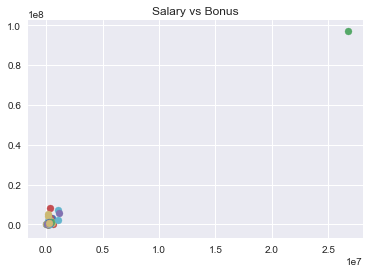

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

features = ['salary', 'bonus']
data = featureFormat(my_dataset, features)

for person in data:
    salary = person[0]
    bonus = person[1]
    plt.scatter(salary, bonus)
    plt.title('Salary vs Bonus')

It looks like we have an outlier. Let's dig in.

In [8]:
outlier = max(data,key=lambda item:item[1])
print (outlier)

for person in my_dataset:
    if my_dataset[person]['salary'] == outlier[0] and my_dataset[person]['bonus'] == outlier[1]:
        print (person)

[ 26704229.  97343619.]
TOTAL


Our outlier is simply the total of all other individuals. It is not useful for what we want to do: let's get rid of it. As long as we're visualizing, we'll have to modify both the dictionary and the dataframe. Once we get to the classification, we will focus on the dictionary.

In [9]:
my_dataset.pop('TOTAL', 0)
data = featureFormat(my_dataset, features)

In [10]:
len(my_dataset)

145

Our `TOTAL` entry was removed as expected. Let's plot it again, making sure to redefine our dataframe first:

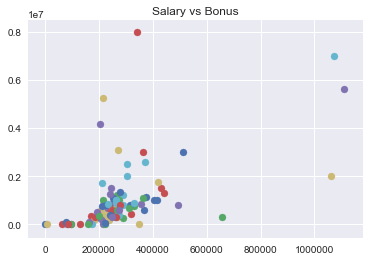

In [11]:
for person in data:
    salary = person[0]
    bonus = person[1]
    plt.scatter(salary, bonus)
    plt.title('Salary vs Bonus')

This looks much better. We are now going to identify other outliers, on arbitrary basis: we will define an outlier as someone whose salary was superior to <br />\$ 1,000,000 **AND** whose bonus was superior to \$ 5,000,000.

In [12]:
for person in my_dataset:
    if my_dataset[person]['salary'] != 'NaN' and my_dataset[person]['bonus'] != 'NaN' and my_dataset[person]['salary'] >= 1000000 and my_dataset[person]['bonus'] >= 5000000:
        print (person, 'Salary:', my_dataset[person]['salary'], 'Bonus:', my_dataset[person]['bonus'])

LAY KENNETH L Salary: 1072321 Bonus: 7000000
SKILLING JEFFREY K Salary: 1111258 Bonus: 5600000


Two persons correspond to our investigation:
- **Kenneth L. Lay**, CEO and then Chairman of Enron Corporation
- **Jeffrey K. Skilling**, COO and then CEO of Enron Corporation

## Creating new features

> What features did you end up using in your POI identifier, and what selection process did you use to pick them? Did you have to do any scaling? Why or why not? As part of the assignment, you should attempt to engineer your own feature that does not come ready-made in the dataset -- explain what feature you tried to make, and the rationale behind it. (You do not necessarily have to use it in the final analysis, only engineer and test it.) In your feature selection step, if you used an algorithm like a decision tree, please also give the feature importances of the features that you use, and if you used an automated feature selection function like SelectKBest, please report the feature scores and reasons for your choice of parameter values.  [relevant rubric items: “create new features”, “intelligently select features”, “properly scale features”]

We could create new interesting features from the ones we already have. For example, we can assume that POIs
exchange send more emails to other POIs than non-POIs. Let's create features that hold these ratios.

In [13]:
for person in my_dataset:
    if my_dataset[person]['from_poi_to_this_person'] != 'NaN' and my_dataset[person]['from_this_person_to_poi'] != 'NaN':
        my_dataset[person]['from_poi_ratio'] = my_dataset[person]['from_poi_to_this_person'] / my_dataset[person]['to_messages']
        my_dataset[person]['to_poi_ratio'] = my_dataset[person]['from_this_person_to_poi'] / my_dataset[person]['from_messages']
    else:
        my_dataset[person]['from_poi_ratio'] = 'NaN'
        my_dataset[person]['to_poi_ratio'] = 'NaN'

Let's now generate a scatter plot distinguishing between POIs and non-POIs, and check if our assumptions were right.

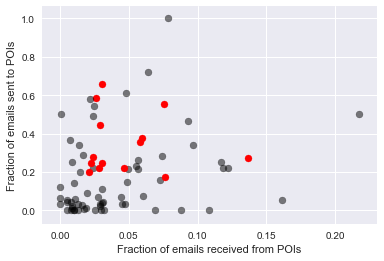

In [14]:
features = ['poi', 'from_poi_ratio', 'to_poi_ratio']
data = featureFormat(my_dataset, features)

for person in data:
    x = person[1]
    y = person[2]
    if person[0] == 0:
        plt.scatter(x, y, color='black', alpha=0.5)
    else:
        plt.scatter(x, y, color='r')
        
plt.xlabel('Fraction of emails received from POIs')
plt.ylabel('Fraction of emails sent to POIs')

It's hard to conclude anything from this. Although it appears that POIs do exchange a lot of emails, it seems hasty to conclude that it can be confidently used as a predictive feature.  

In the next part, we're actually going to use feature selection and dimension reduction to select the strongest variables to do the job.

## Testing classifiers

In [15]:
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'total_payments', 'loan_advances', 
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'director_fees',
                 'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio']

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

We took care of putting `poi` first, because that's what the algorithm expects to recognize it as the label. We also got rid of non-numercial values. Now that the preparation is done, we're ready to test different classifiers.

In [16]:
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.3, random_state=42)
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train, labels_train)
gnb_pred = clf.predict(features_test)
gnb_score = clf.score(features_test, labels_test)
gnb_precision = precision_score(labels_test, gnb_pred)
gnb_recall = recall_score(labels_test, gnb_pred)
print ('GaussianNB accuracy:', gnb_score)
print ('GaussianNB precision:', gnb_precision)
print ('GaussianNB recall:', gnb_recall, '\n')


from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)
fit = clf.fit(features_train, labels_train)
dt_pred = clf.predict(features_test, labels_test)
dt_score = clf.score(features_test, labels_test)
dt_precision = precision_score(labels_test, dt_pred)
dt_recall = recall_score(labels_test, dt_pred)
print ('Decision Tree accuracy:', dt_score)
print ('Decision Tree precision:', dt_precision)
print ('Decision Tree recall:', dt_recall, '\n')


from sklearn.svm import SVC
clf = SVC(random_state=0)
fit = clf.fit(features_train, labels_train)
svc_pred = clf.predict(features_test)
svc_score = clf.score(features_test, labels_test)
svc_precision = precision_score(labels_test, svc_pred)
svc_recall = recall_score(labels_test, svc_pred)
print ('SVC accuracy:', svc_score)
print ('SVC precision:', svc_precision)
print ('SVC recall:', svc_recall, '\n')


from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=0)
fit = clf.fit(features_train, labels_train)
rf_pred = clf.predict(features_test)
rf_score = clf.score(features_test, labels_test)
rf_precision = precision_score(labels_test, rf_pred)
rf_recall = recall_score(labels_test, rf_pred)
print ('Random Forest accuracy:', rf_score)
print ('Random Forest precision:', rf_precision)
print ('Random Forest recall:', rf_recall, '\n')


from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
fit = clf.fit(features_train, labels_train)
kn_pred = clf.predict(features_test)
kn_score = clf.score(features_test, labels_test)
kn_precision = precision_score(labels_test, kn_pred)
kn_recall = recall_score(labels_test, kn_pred)
print ('K Neighbors accuracy:', kn_score)
print ('K Neighbors precision:', kn_precision)
print ('K Neighbors recall:', kn_recall, '\n')

GaussianNB accuracy: 0.227272727273
GaussianNB precision: 0.108108108108
GaussianNB recall: 0.8 

Decision Tree accuracy: 0.704545454545
Decision Tree precision: 0.214285714286
Decision Tree recall: 0.6 

SVC accuracy: 0.886363636364
SVC precision: 0.0
SVC recall: 0.0 

Random Forest accuracy: 0.886363636364
Random Forest precision: 0.5
Random Forest recall: 0.2 

K Neighbors accuracy: 0.886363636364
K Neighbors precision: 0.5
K Neighbors recall: 0.2 



## Chosing and optimizing an algorithm 

We're going to go with the Decision Tree algorithm because it seems to have a good, consistent performance overall.
This algorithm also has a few advantages:
- it completes feature selection automatically
- it doesn't require feature scaling (variable transformation or normalization)
- it is not impacted by missing values (and we have a lot of these)
- it is robust to non-linear relationships
- they are intuitive and easy to explain when communicating results and insights

## Feature selection

In [17]:
clf = DecisionTreeClassifier(random_state=0)
fit = clf.fit(features_train, labels_train)
dt_pred = clf.predict(features_test, labels_test)
dt_score = clf.score(features_test, labels_test)
dt_precision = precision_score(labels_test, dt_pred)
dt_recall = recall_score(labels_test, dt_pred)
importance = clf.feature_importances_
print ('Decision Tree accuracy:', dt_score)
print ('Decision Tree precision:', dt_precision)
print ('Decision Tree recall:', dt_recall, '\n')

for i in range(len(importance)):
    print(features_list[i+1], 'importance:', importance[i])

Decision Tree accuracy: 0.704545454545
Decision Tree precision: 0.214285714286
Decision Tree recall: 0.6 

salary importance: 0.0
bonus importance: 0.363998070895
deferral_payments importance: 0.0
total_payments importance: 0.0736811081639
loan_advances importance: 0.0
restricted_stock_deferred importance: 0.0
deferred_income importance: 0.0
total_stock_value importance: 0.0
expenses importance: 0.0208931361506
exercised_stock_options importance: 0.212249881456
long_term_incentive importance: 0.0663129973475
restricted_stock importance: 0.0
director_fees importance: 0.0
shared_receipt_with_poi importance: 0.178534992859
from_poi_ratio importance: 0.0
to_poi_ratio importance: 0.0843298131289


We're going to use `SelectKBest` to choose which features we're going to include in our final list. SelectKBest simply removes all but the k highest scoring features.

In [18]:
from sklearn.feature_selection import SelectKBest, f_classif

kbest = SelectKBest(f_classif, k=5)
features_selected = kbest.fit_transform(features_train, labels_train)
print(features_selected.shape)

final_features = [features_list[i+1] for i in kbest.get_support(indices=True)]
print ('Features selected by SelectKBest:')
print (final_features)

(100, 5)
Features selected by SelectKBest:
['bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'to_poi_ratio']


According to our results, the top 5 features we should use are `['bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'to_poi_ratio']`

We're going to test different classifiers on our selected features once again.

In [19]:
features_select = ['poi', 'bonus', 'total_stock_value', 'expenses', 'exercised_stock_options', 'to_poi_ratio']
data = featureFormat(my_dataset, features_select)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.3, random_state=42)

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(features_train, labels_train)
gnb_pred = clf.predict(features_test)
gnb_score = clf.score(features_test, labels_test)
gnb_precision = precision_score(labels_test, gnb_pred)
gnb_recall = recall_score(labels_test, gnb_pred)
print ('GaussianNB accuracy:', gnb_score)
print ('GaussianNB precision:', gnb_precision)
print ('GaussianNB recall:', gnb_recall, '\n')

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier()
fit = clf.fit(features_train, labels_train)
kn_pred = clf.predict(features_test)
kn_score = clf.score(features_test, labels_test)
kn_precision = precision_score(labels_test, kn_pred)
kn_recall = recall_score(labels_test, kn_pred)
print ('K Neighbors accuracy:', kn_score)
print ('K Neighbors precision:', kn_precision)
print ('K Neighbors recall:', kn_recall, '\n')

clf = DecisionTreeClassifier(random_state=0)
fit = clf.fit(features_train, labels_train)
dt_pred = clf.predict(features_test, labels_test)
dt_score = clf.score(features_test, labels_test)
dt_precision = precision_score(labels_test, dt_pred)
dt_recall = recall_score(labels_test, dt_pred)
print ('Decision Tree accuracy:', dt_score)
print ('Decision Tree precision:', dt_precision)
print ('Decision Tree recall:', dt_recall, '\n')

GaussianNB accuracy: 0.857142857143
GaussianNB precision: 0.666666666667
GaussianNB recall: 0.5 

K Neighbors accuracy: 0.833333333333
K Neighbors precision: 1.0
K Neighbors recall: 0.125 

Decision Tree accuracy: 0.809523809524
Decision Tree precision: 0.5
Decision Tree recall: 0.125 



Our feature selection does not seem to have an interesting impact over our classifiers. In the next phase, we will let `SelectKBest` be the judge directly during the optimization.

## Optimizing our algorithms, validating and evaluating metrics

We are aiming to achieve a precision and recall better than .3, and in general, the best possible.
 
We will now optimize our classifiers. We will test run them with their default parameters before trying to optimize them.

First, we're going to reset our list, features and labels, and let SelectKBest do the job each time.

In [20]:
features_list = ['poi', 'salary', 'bonus', 'deferral_payments', 'total_payments', 'loan_advances', 
                 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'long_term_incentive', 'restricted_stock', 'director_fees',
                 'shared_receipt_with_poi', 'from_poi_ratio', 'to_poi_ratio']
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.3, random_state=42)

Validation is important in machine learning, and it needs to be executed the right way to avoid over-fitting. When this happens, our algorithm will perform extremely well on the trained data, but will be unable to generalize to the test data.

We will be using `StratifiedShuffleSplit` for validation. This cross validation object returns stratified randomized folds, and fits the structure of our unbalanced data (a lot more non-POIs than POIs).

We're going to use two validation metrics, **precision** and **recall**. In the context of this project:
- precision measures how many positive predictions were actual positive observations, that is, the proportion of predicted POIs that were actually POIs
- recall measures how many positive observations were predicted correctly, that is, the proportion of actual POIs that were predicted correctly

We will start with a `GaussianNB` classifier: there are no parameters to select, so it will give us a good base line.

In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tester import test_classifier

scaler = MinMaxScaler()
select = SelectKBest()
gnb = GaussianNB()

steps = [('scaler', scaler),
         ('feature_select', select),
         ('classifier', gnb)]

param_grid = {'feature_select__k': range(1,17)}
sss = StratifiedShuffleSplit(100, test_size=0.3, random_state = 0)
pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')

gs.fit(features_train, labels_train)
clf = gs.best_estimator_

test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_select', SelectKBest(k=11, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.84800	Precision: 0.40979	Recall: 0.31800	F1: 0.35811	F2: 0.33291
	Total predictions: 15000	True positives:  636	False positives:  916	False negatives: 1364	True negatives: 12084



Let's now run a `KNeighbors` classifier with its default parameters:

In [22]:
kn = KNeighborsClassifier()

steps = [('scaler', scaler),
         ('feature_select', select),
         ('classifier', kn)]

param_grid = {'feature_select__k': range(1,17)}

pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')
gs.fit(features_train, labels_train)
gs.best_params_

clf = gs.best_estimator_
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_select', SelectKBest(k=14, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.85013	Precision: 0.17021	Recall: 0.03200	F1: 0.05387	F2: 0.03820
	Total predictions: 15000	True positives:   64	False positives:  312	False negatives: 1936	True negatives: 12688



Now let's tune the `KNeighbors` parameters:

In [23]:
param_grid = {'feature_select__k': range(1,17),
              'classifier__n_neighbors': np.arange(3, 10),
              'classifier__weights': ['uniform', 'distance'],
              'classifier__algorithm': ['ball_tree', 'kd_tree', 'brute']}

pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')
gs.fit(features_train, labels_train)
gs.best_params_

clf = gs.best_estimator_
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_select', SelectKBest(k=3, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance'))])
	Accuracy: 0.84993	Precision: 0.40613	Recall: 0.27150	F1: 0.32544	F2: 0.29078
	Total predictions: 15000	True positives:  543	False positives:  794	False negatives: 1457	True negatives: 12206



Lastly let's try a `DecisionTree` with default parameters. We will omit the scaling step since the algorithm does it automatically.

In [24]:
dtc = DecisionTreeClassifier(random_state=0)

steps = [('feature_select', select),
         ('classifier', dtc)]

param_grid = {'feature_select__k':range(1,17)}

pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')
gs.fit(features, labels)
gs.best_params_

clf = gs.best_estimator_
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('feature_select', SelectKBest(k=7, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'))])
	Accuracy: 0.81007	Precision: 0.27717	Recall: 0.26400	F1: 0.27042	F2: 0.26653
	Total predictions: 15000	True positives:  528	False positives: 1377	False negatives: 1472	True negatives: 11623



Now let's tune the `DecisionTree` parameters:

In [25]:
steps = [('feature_select', select),
         ('classifier', dtc)]

param_grid = {'feature_select__k':range(1,17),
              'classifier__max_depth': np.arange(3, 10),
              'classifier__presort': [True, False],
              'classifier__min_samples_split': np.arange(3, 10)}

pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')

gs.fit(features, labels)
gs.best_params_

gs.best_estimator_
test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('feature_select', SelectKBest(k=7, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'))])
	Accuracy: 0.81007	Precision: 0.27717	Recall: 0.26400	F1: 0.27042	F2: 0.26653
	Total predictions: 15000	True positives:  528	False positives: 1377	False negatives: 1472	True negatives: 11623



We know now which parameters we should use with each classifier to obtain the best performance possible.  

It seems like our Gaussian Naive Bayes classifier performs best, so we will go with this one.

In [26]:
from sklearn.metrics import accuracy_score

score_list = []

scaler = MinMaxScaler()
select = SelectKBest()
gnb = GaussianNB()

steps = [('scaler', scaler),
         ('feature_select', select),
         ('classifier', gnb)]

param_grid = {'feature_select__k': range(1,17)}
sss = StratifiedShuffleSplit(100, test_size=0.3, random_state = 0)
pipe = Pipeline(steps)
gs = GridSearchCV(pipe, param_grid, cv=sss, scoring='f1')

gs.fit(features_train, labels_train)
clf = gs.best_estimator_

test_classifier(clf, my_dataset, features_list)

Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_select', SelectKBest(k=11, score_func=<function f_classif at 0x115d8d1e0>)), ('classifier', GaussianNB(priors=None))])
	Accuracy: 0.84800	Precision: 0.40979	Recall: 0.31800	F1: 0.35811	F2: 0.33291
	Total predictions: 15000	True positives:  636	False positives:  916	False negatives: 1364	True negatives: 12084



## Dumping the classifier, dataset and feature_list

In [27]:
from tester import dump_classifier_and_data

dump_classifier_and_data(clf, my_dataset, features_list)

# Conclusions

We need to keep in mind that we dealt with a small, unbalanced dataset (an overwhelming majority of the dataset is comprised of non-POIs). This should make us cautious of our conclusions.

Still, now we have a classifier that can help us identify POIs. Basically, we have a 84.8% chance that a person identified as a POI by the classifier is actually a POI, and 1 chance out of 3 of catching a POI.

These scores are still pretty low. This analysis focused on financial data, but we also have a huge corpus of emails at our disposal. Analyzing this corpus to uncover patterns would at least help, and probably give us more material to detect and correctly flag POIs.

Another possible approach would be to use deep learning. Maybe this would help reveal associations we didn't think about. 

## Possible improvements

- There are other outliers that could be removed:
    - There's an observation that has no non NaN values
    - There's an observation that isn't a real person
- Features like `from_poi_to_this_person` and `from_this_person_to_poi`, `shared_receipt_with_poi` can potentially create a [data leakage](https://www.kaggle.com/wiki/Leakage) (the creation of unexpected additional information in the training data, allowing a model or machine learning algorithm to make unrealistically good predictions). This can hamper the model's ability to generalize on unseen data and can give the false effect that the model performs really well. These features contain information that is used to create the feature, while also containing information about the target (POI/Non-POI).